# Bibliotecas

In [1]:
import pywt
import utils
import random 
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

# Configuración Inicial

In [2]:
# Establecemos los parámetros del filtro pasa banda

freq_min = 5                  # Límite inferior del filtro (Hz)
freq_max = 40                 # Límite superior del filtro (Hz)
fs_eeg = 250                  # Tasa de muestreo (Hz)

# Diseño de filtro Butterworth de cuarto orden en el rango 5-40 Hz
coef_b, coef_a = signal.butter(4, [freq_min, freq_max], fs=fs_eeg, btype='band')

# Recuperación de información auxiliar del conjunto de datos SSVEP
# Devuelve:
# - stim_freqs: frecuencias de estímulo (Hz)
# - ch_names: etiquetas de los 64 electrodos
stim_freqs, ch_names = utils.load_ssvep_additional_info("Database BETA/S1")

# Identificamos los electrodos de la zona occipital (con 'O' en el nombre)
# Esta región está implicada en el procesamiento visual
# Obtenemos:
# - occipital_info: pares [índice, nombre]
# - occipital_idxs: solo los índices
# - occipital_labels: solo los nombres
occipital_info, occipital_idxs, occipital_labels = utils.select_occipital_electrodes(ch_names)

# Cálculo de muestras sin estímulo (medio segundo al inicio del ensayo)
n_samples_blank = int(0.5 * fs_eeg)



# Espectrograma

En esta sección mostraremos parte del proceso utilizado para generar las representaciones espectrográficas de las señales EEG, así como la selección de los parámetros empleados para su cálculo.

El espectrograma nos permite observar cómo varía el contenido frecuencial de la señal a lo largo del tiempo, lo cual es especialmente útil para analizar respuestas SSVEP con frecuencias que cambian o aparecen en intervalos específicos.


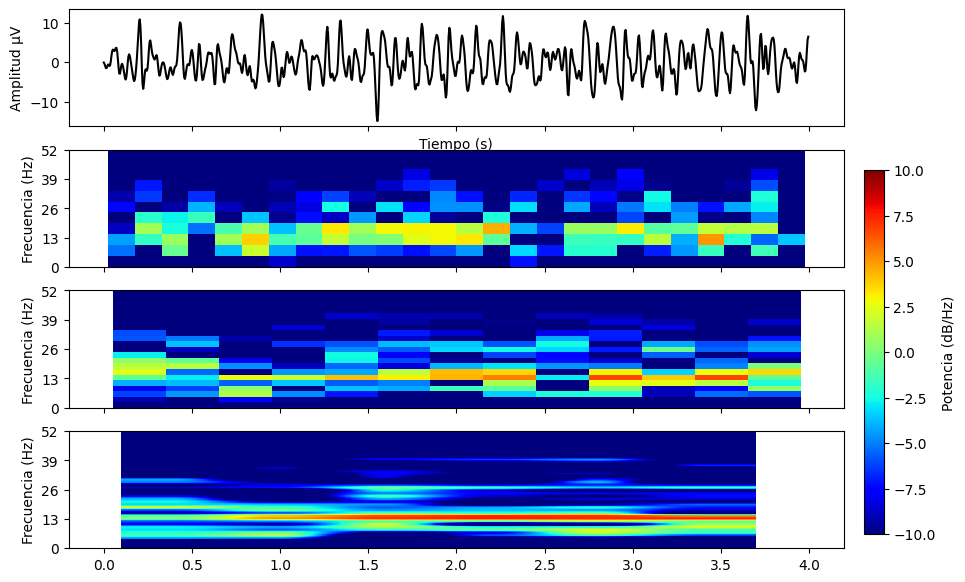

In [3]:
# Cargamos los datos correspondientes al sujeto número 23
# señal_completa: señal EEG original
# señal_sin_reposo: señal EEG excluyendo los segmentos sin estímulo
# duracion_trial: duración del ensayo en segundos
señal_completa, señal_sin_reposo, duracion_trial = utils.load_ssvep_data("Database BETA/", 23)

# Definimos el eje temporal correspondiente a 1000 muestras (4 segundos a 250 Hz)
tiempo = np.arange(0, 1000 / fs_eeg, 1 / fs_eeg)

# Seleccionamos una de las frecuencias de estímulo (índice 22)
idx_frec = 22
frec_objetivo = stim_freqs[idx_frec]

# === Parámetros del análisis espectral ===
fs_actual = fs_eeg
registro_oz = señal_completa[61, :, 0, idx_frec]  # canal Oz

# Filtrado de la señal con filtro Butterworth previamente definido
senal_proc = signal.lfilter(coef_b, coef_a, registro_oz)

# Creamos la figura con 4 subgráficas verticales compartiendo eje x
figura_espectros, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 7), sharex=True)

# === ax1: Señal temporal filtrada ===
ax1.plot(tiempo, senal_proc, color='black')
ax1.set_ylabel("Amplitud " + '\u03BC' + "V")
ax1.set_xlabel("Tiempo (s)")
ax1.set_xlim(0, 4)

# Definimos el rango de frecuencias a representar
frecs_mostrar = (0, 50)

# Escala para los valores de potencia del espectrograma
escala_potencia = (-10, 10)

# Diferentes tamaños de ventana (en muestras) y sus solapamientos (25%)
ventanas_fft = [50, 100, 200]
solapamientos_fft = [int(w / 4) for w in ventanas_fft]

# === ax2: Espectrograma con ventana 50 ===
potencia_1, frec_axis_1, t_axis_1, imagen = ax2.specgram(
    senal_proc, NFFT=ventanas_fft[0], Fs=fs_actual,
    noverlap=solapamientos_fft[0], cmap='jet',
    vmin=escala_potencia[0], vmax=escala_potencia[1]
)
ax2.set_ylabel('Frecuencia (Hz)')
ax2.set_ylim(frecs_mostrar)
ax2.set_yticks([0, frec_objetivo, frec_objetivo*2, frec_objetivo*3, frec_objetivo*4])
ax2.set_xticks(np.arange(0, 4.5, 0.5))
ax2.set_xlim(0, 4)

# === ax3: Espectrograma con ventana 100 ===
ax3.specgram(
    senal_proc, NFFT=ventanas_fft[1], Fs=fs_actual,
    noverlap=solapamientos_fft[1], cmap='jet',
    vmin=escala_potencia[0], vmax=escala_potencia[1]
)
ax3.set_ylabel('Frecuencia (Hz)')
ax3.set_ylim(frecs_mostrar)
ax3.set_yticks([0, frec_objetivo, frec_objetivo*2, frec_objetivo*3, frec_objetivo*4])

# === ax4: Espectrograma con ventana 200 ===
ax4.specgram(
    senal_proc, NFFT=ventanas_fft[2], Fs=fs_actual,
    noverlap=solapamientos_fft[2], cmap='jet',
    vmin=escala_potencia[0], vmax=escala_potencia[1]
)
ax4.set_ylabel('Frecuencia (Hz)')
ax4.set_ylim(frecs_mostrar)
ax4.set_yticks([0, frec_objetivo, frec_objetivo*2, frec_objetivo*3, frec_objetivo*4])

# Añadimos una barra de color común para los espectrogramas
barra_color_global = figura_espectros.add_axes([0.92, 0.13, 0.02, 0.52])
plt.colorbar(imagen, cax=barra_color_global, label='Potencia (dB/Hz)')

# Mostrar la visualización final
plt.show()




# Transformada Wavelet

En esta sección mostraremos parte del proceso para generar representaciones utilizando la transformada wavelet, así como la selección de los parámetros necesarios.

La transformada wavelet continua (CWT) permite analizar cómo varía el contenido frecuencial de una señal en el tiempo, ofreciendo **mayor resolución a bajas frecuencias** y **mejor precisión temporal a frecuencias altas**, lo que la hace especialmente útil para estudiar respuestas SSVEP en señales EEG.


C:\Users\javie\AppData\Local\Temp\ipykernel_14320\3337253368.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


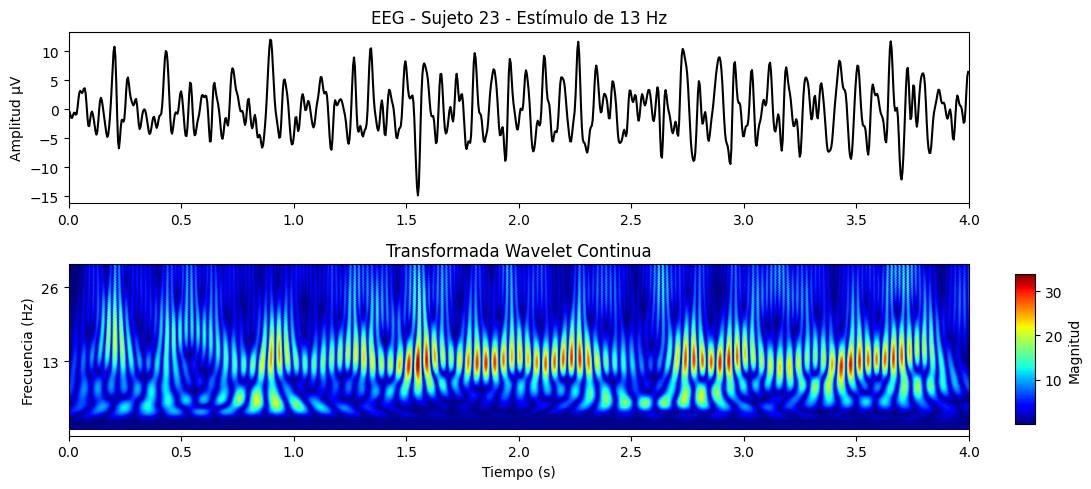

In [4]:
# Cargamos el registro EEG del sujeto 23
# registro_bruto: señal original completa
# registro_estimulado: señal que excluye los periodos sin estímulo
# duracion_segundos: duración del ensayo
registro_bruto, registro_estimulado, duracion_segundos = utils.load_ssvep_data("Database BETA/", 23)

# Definimos el vector temporal para 1000 muestras (4 segundos a 250 Hz)
tiempo_eeg = np.arange(0, 1000 / fs_eeg, 1 / fs_eeg)

# Confirmamos la frecuencia de muestreo
fs_eeg = 250

# Filtrado de la señal EEG en el canal Oz (índice 61), ensayo 0, frecuencia índice 22
senal_filtrada = signal.lfilter(coef_b, coef_a, registro_bruto[61, :, 0, 22])

# Generamos un rango de frecuencias entre 1 y 40 Hz con resolución 0.01 Hz
# Las normalizamos para convertir a escalas compatibles con la wavelet
frecs_deseadas = np.arange(1, 40, 0.01) / fs_eeg

# Especificamos la wavelet base (Morlet)
wavelet_tipo = "morl"

# Convertimos las frecuencias normalizadas en escalas equivalentes
escalas = pywt.frequency2scale(wavelet_tipo, frecs_deseadas)

# Ejecutamos la Transformada Wavelet Continua sobre la señal filtrada
# Se obtiene una matriz compleja de coeficientes
coef_wavelet, frecuencias_wavelet = pywt.cwt(senal_filtrada, escalas, wavelet_tipo)

# Recuperamos las frecuencias reales multiplicando por la tasa de muestreo
frecs_reales = frecs_deseadas * fs_eeg

# Creamos figura con dos subgráficas: señal en el tiempo + espectrograma wavelet
figura_cwt, (eje1, eje2) = plt.subplots(nrows=2, figsize=(10, 5))

# === eje1: señal EEG filtrada ===
eje1.plot(tiempo_eeg, senal_filtrada, 'k')
eje1.set_xlim(0, 4)
eje1.set_ylabel("Amplitud " + '\u03BC' + "V")
eje1.set_title("EEG - Sujeto 23 - Estímulo de 13 Hz")

# === eje2: CWT ===
eje2.imshow(
    np.abs(coef_wavelet),                  # Magnitud de la transformada
    aspect='auto',
    cmap='jet',
    extent=[0, len(tiempo_eeg) / fs_eeg, frecs_reales[-1], frecs_reales[0]],
    origin='upper'
)
eje2.set_xlabel('Tiempo (s)')
eje2.set_ylabel('Frecuencia (Hz)')
eje2.set_title("Transformada Wavelet Continua")
eje2.set_ylim(0, 30)
eje2.set_yticks([13, 26])  # Frecuencia fundamental y primer armónico

# Añadimos una barra de color para visualizar la magnitud
barra_color = figura_cwt.add_axes([1.02, 0.14, 0.02, 0.3])
plt.colorbar(eje2.images[0], cax=barra_color, label="Magnitud")

# Ajuste de distribución entre subgráficas
plt.tight_layout()



# Tiempos Específicos

En esta sección cargaremos los datos obtenidos mediante el enfoque de **ventanas deslizantes** con el objetivo de determinar las áreas temporales en las que se detectó correctamente el estímulo. Esta información se utilizará para **sombrear visualmente** las regiones correspondientes en nuestras representaciones, facilitando la interpretación temporal de los resultados.


In [5]:
# Recuperamos los resultados almacenados de las detecciones mediante ventanas deslizantes
# Cada archivo contiene, por sujeto, ensayo y frecuencia, la muestra en la que se detectó
# correctamente el estímulo o un -1 si no hubo detección válida.

# Detecciones con PSDA modificado usando ventanas móviles
detecciones_psda_mod = utils.cargar_datos("Datos Guardados/psda_m_deslizante.h5")

# Detecciones con el método CCA utilizando ventanas móviles
detecciones_cca_movil = utils.cargar_datos("Datos Guardados/cca_deslizante.h5")


Datos cargados correctamente desde Datos Guardados/psda_m_deslizante.h5
Datos cargados correctamente desde Datos Guardados/cca_deslizante.h5


In [6]:
# Función para mostrar en qué instante (en muestras) se detectó una frecuencia usando CCA
# para los cuatro ensayos de un sujeto determinado. Si no se detecta, se indica igualmente.

def mostrar_tiempo_deteccion(sujeto_id, idx_frecuencia):
    for ensayo in range(4):
        muestra = detecciones_cca_movil[sujeto_id - 1, ensayo, idx_frecuencia]
        if muestra != -1:
            print("Sujeto", sujeto_id,
                  "- frecuencia", stim_freqs[idx_frecuencia], "Hz detectada en la muestra",
                  muestra, "en el ensayo", ensayo + 1)
        else:
            print("No se detectó la frecuencia", stim_freqs[idx_frecuencia],
                  "Hz con CCA para el sujeto", sujeto_id, "en el ensayo", ensayo + 1)

In [7]:
# Función que retorna la muestra en la que se detectó una frecuencia específica
# para un sujeto, ensayo y frecuencia determinados.

def obtener_muestra_deteccion(id_sujeto, idx_freq, idx_ensayo, matriz_deteccion):
    return matriz_deteccion[id_sujeto - 1, idx_ensayo, idx_freq]



## m_PSDA

In [8]:
# Inicializamos una lista vacía para guardar las muestras donde se detectó la frecuencia con PSDA modificado
muestras_detectadas = []

# Sujetos incluidos en el análisis
grupo_sujetos = [18, 64, 11, 67]

# Frecuencias (índices) seleccionadas para validación
indices_frecuencia = [12, 22, 0, 35]

# Recorremos cada sujeto, frecuencia y ensayo para almacenar los valores detectados
for sujeto in grupo_sujetos:
    for freq in indices_frecuencia:
        for ensayo in range(4):
            muestra = obtener_muestra_deteccion(sujeto, freq, ensayo, detecciones_psda_mod)
            muestras_detectadas.append(muestra)

# Imprimimos el resultado
print(muestras_detectadas)



[125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, -1.0, -1.0, 125.0, -1.0, -1.0, -1.0, -1.0, -1.0, 215.0, 125.0, 125.0, 205.0, 605.0, 555.0, 415.0, 165.0, -1.0, 135.0, -1.0, 395.0, -1.0, -1.0, -1.0, -1.0, 195.0, 135.0, 355.0, 355.0, 125.0, 345.0, 235.0, 355.0, 125.0, 125.0, 255.0, 185.0, -1.0, -1.0, -1.0, -1.0, 125.0, 235.0, 325.0, 125.0, 135.0, 125.0, 285.0, 225.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


In [9]:
muestras_psda_mod = muestras_detectadas

## CCA

In [10]:
# Lista vacía para registrar las muestras detectadas mediante el método CCA
muestras_cca = []

# Sujetos incluidos en el análisis
grupo_sujetos = [18, 64, 11, 67]

# Índices de las frecuencias objetivo
indices_frecuencia = [12, 22, 0, 35]

# Recorremos combinaciones de sujeto, frecuencia y ensayo
for sujeto in grupo_sujetos:
    for idx_frec in indices_frecuencia:
        for ensayo in range(4):
            muestra_detectada = obtener_muestra_deteccion(sujeto, idx_frec, ensayo, detecciones_cca_movil)
            muestras_cca.append(muestra_detectada)

# Visualizamos las muestras detectadas (como índices, no tiempo en segundos)
print(muestras_cca)


[185.0, 165.0, 125.0, 185.0, 125.0, 145.0, 155.0, 155.0, 255.0, 155.0, 135.0, 145.0, 145.0, 125.0, 125.0, 205.0, 215.0, 125.0, 135.0, 215.0, 605.0, 585.0, 445.0, 275.0, -1.0, -1.0, 685.0, -1.0, 525.0, -1.0, -1.0, -1.0, 185.0, -1.0, -1.0, -1.0, 465.0, -1.0, -1.0, 395.0, 415.0, 495.0, 235.0, 175.0, 405.0, -1.0, -1.0, 325.0, 125.0, 205.0, 325.0, 125.0, 395.0, 185.0, 565.0, 405.0, 125.0, 125.0, 145.0, 125.0, 485.0, 545.0, 645.0, 625.0]


In [11]:
muestras_cca_mod = muestras_cca

# Generación Final de Imágenes

En esta sección generaremos las representaciones visuales finales utilizando los resultados obtenidos. Estas imágenes incluirán las zonas donde se detectaron correctamente los estímulos (sombreando las regiones temporales correspondientes), y servirán como parte del análisis visual para comparar los métodos utilizados (PSDA modificado, CCA, etc.).


In [12]:
# Definición de los parámetros usados en las ventanas deslizantes de PSDA y CCA

# Tamaño de cada ventana en muestras
# Se toma 750 como longitud mínima del ensayo (3 segundos a 250 Hz)
# Se divide entre 3 para usar ventanas de 1 segundo
tam_ventana = int(750 / 3)

# Desplazamiento entre ventanas consecutivas (en muestras)
# Un paso pequeño da mayor resolución temporal
desplazamiento = 10  # Equivale a 40 ms con fs = 250 Hz

# Mostramos los valores utilizados y el número total de ventanas generadas
# - Para ensayos de 750 muestras
# - Para ensayos de 1000 muestras
print("Tamaño de ventana =", tam_ventana)
print("Desplazamiento entre ventanas =", desplazamiento)
print("Total de ventanas (750 muestras):", len(np.arange(0, 750, step=desplazamiento)),
      "y (1000 muestras):", len(np.arange(0, 1000, step=desplazamiento)))


Tamaño de ventana = 250
Desplazamiento entre ventanas = 10
Total de ventanas (750 muestras): 75 y (1000 muestras): 100


In [13]:
# Preparamos los datos de detección para visualización como zonas sombreadas

# Inicializamos una matriz de ceros de tamaño (64, 2)
# Cada fila corresponde a una combinación única de sujeto, frecuencia y ensayo
# - Columna 0: detecciones con PSDA modificado
# - Columna 1: detecciones con CCA
matriz_detecciones = np.zeros((64, 2))

# Comprobamos dimensiones para verificar que son correctas
print(matriz_detecciones.shape)

# Asignamos los valores previamente calculados a la matriz
for idx in range(matriz_detecciones.shape[0]):
    matriz_detecciones[idx, 0] = muestras_psda_mod[idx]   # PSDA modificado
    matriz_detecciones[idx, 1] = muestras_cca_mod[idx]    # CCA

(64, 2)


## Espectrograma, Transformada Wavelet y FFT

En esta sección se presentan las tres representaciones más utilizadas para el análisis tiempo-frecuencia de señales EEG:

- **Espectrograma (STFT)**: permite visualizar cómo varía el contenido frecuencial de la señal a lo largo del tiempo mediante ventanas de Fourier.
- **Transformada Wavelet Continua (CWT)**: ofrece una resolución adaptativa, ideal para observar cambios en distintas bandas de frecuencia.
- **Transformada Rápida de Fourier (FFT)**: análisis frecuencial global de la señal, sin información temporal.

Estas herramientas nos permiten comparar y validar la presencia de componentes de estímulo (como frecuencias SSVEP) y su evolución en el tiempo.


In [15]:
# Inicializamos el índice usado para recorrer la matriz de muestras 'matriz_detecciones'
indice_muestra = 0

# Frecuencia de muestreo del EEG
fs = 250

# Cargamos información adicional de un sujeto cualquiera para obtener nombres de electrodos y frecuencias
sujeto_ref = 41  # Se usa únicamente para cargar el archivo S41.mat
ruta_info = "Database BETA/S" + str(sujeto_ref) + ".mat"
stim_freqs, ch_names = utils.load_ssvep_additional_info(ruta_info)

# Identificamos los electrodos occipitales
info_occipital, idxs_occipitales, nombres_occipitales = utils.select_occipital_electrodes(ch_names)

# Cálculo de muestras sin estímulo (0,5 segundos al inicio)
n_sin_estimulo = int(0.5 * fs)

# Cargamos inicialmente los datos del sujeto 18
registro_eeg, registro_estimulado, duracion_ensayo = utils.load_ssvep_data("Database BETA/", 18)

# Pares de frecuencias a representar para cada sujeto (una buena y una mala)
frecs_por_caso = [[11, 13], [8.6, 15.6],
                  [11, 13], [8.6, 15.6],
                  [11, 13], [8.6, 15.6],
                  [11, 13], [8.6, 15.6]]

# Sujetos seleccionados para análisis visual
sujetos_analizados = [18, 18, 64, 64, 11, 11, 67, 67]

# Etiquetas que identifican cada combinación sujeto/frecuencia
etiquetas_casos = ["best", "worst", "best", "worst",
                   "paper_worst_best", "paper_worst_worst",
                   "paper_best_best", "paper_best_worst"]

# Corregimos manualmente una frecuencia mal definida en la base de datos
stim_freqs[-5] = 15.6

# Índice y nombre del electrodo OZ
canal_idx = 61
nombre_canal = "OZ"

# Bucle principal: generamos imágenes para todos los sujetos y frecuencias
for i in range(len(sujetos_analizados)):
    sujeto = sujetos_analizados[i]
    
    # Cargamos los datos del sujeto
    registro_eeg, registro_estimulado, duracion_ensayo = utils.load_ssvep_data("Database BETA/", sujeto)
    
    tipo_caso = etiquetas_casos[i]
    
    for j in range(2):  # Dos frecuencias por caso (una positiva, otra negativa)
        idx_local = j + 1
        freq_actual = frecs_por_caso[i][j]
        idx_freq_real = 0
        
        for k in range(40):
            if stim_freqs[k] == freq_actual:
                idx_freq_real = k
                break
        
        # Para cada ensayo (4 por frecuencia)
        for ensayo_idx in range(4):
            # Ruta para guardar espectrograma + wavelet
            ruta_espectro = "Imágenes/Resultados/"
            ruta_espectro += "S" + str(sujeto) + "_" + nombre_canal + "_" + tipo_caso + "_" + str(idx_local) + "_T" + str(ensayo_idx) + ".png"
            
            # Generación de imagen combinada
            utils.generar_visualizacion_wavelet_espectrograma(
                registro_eeg[canal_idx, :, ensayo_idx, idx_freq_real],
                fs,
                idx_freq_real,
                stim_freqs,
                mostrar=False,
                guardar=True,
                ruta_salida=ruta_espectro,
                zonas_sombreadas=matriz_detecciones[indice_muestra],
                duracion_sombra=tam_ventana
            )

            # Ruta para la imagen FFT
            ruta_fft = "Imágenes/Resultados/"
            ruta_fft += "S" + str(sujeto) + "_" + nombre_canal + "_" + tipo_caso + "_" + str(idx_local) + "_T" + str(ensayo_idx) + "_FFT.png"

            # Generación de imagen FFT
            utils.generar_espectro_fft(
                registro_eeg[canal_idx, :, ensayo_idx, idx_freq_real],
                fs=fs,
                frec_estimulacion=stim_freqs[idx_freq_real],
                mostrar=False,
                guardar=True,
                ruta_salida=ruta_fft
            )

            # Avanzamos al siguiente índice de detección
            indice_muestra += 1

# Finalización del proceso
print("¡FINALIZADO!")


c:\Users\javie\OneDrive\Escritorio\UAM\QUINTO\TFG INFO\CÓDIGO\utils.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


¡FINALIZADO!


## Magnitudes máximas a lo largo del tiempo + diferencia media en Hz

En esta sección generamos las imágenes correspondientes para los sujetos seleccionados en el estudio. Analizamos la evolución temporal de las frecuencias con mayor magnitud en cada instante, así como la diferencia media en Hz respecto a la frecuencia de estímulo esperada. 

Esto permite visualizar cómo fluctúan las detecciones y evaluar la precisión temporal del sistema.


In [16]:
# Inicializamos el índice de muestra (no se usa en este fragmento)
indice_actual = 0

# Frecuencia de muestreo del EEG
fs = 250

# Cargamos información auxiliar del sujeto 41 para extraer etiquetas y frecuencias
sujeto_aux = 41
ruta_info = "Database BETA/S" + str(sujeto_aux) + ".mat"
stim_freqs, etiquetas_electrodos = utils.load_ssvep_additional_info(ruta_info)
occipital_info, idxs_occipitales, nombres_occipitales = utils.select_occipital_electrodes(etiquetas_electrodos)

# Muestras iniciales sin estímulo (0,5 segundos)
n_sin_estímulo = int(0.5 * fs)

# Cargamos inicialmente los datos del sujeto 18 como base
registro, registro_sinreposo, duracion_seg = utils.load_ssvep_data("Database BETA/", 18)

# Pares de frecuencias objetivo (una clara y una difícil de detectar)
frecs_objetivo = [[11, 13], [8.6, 15.6],
                  [11, 13], [8.6, 15.6],
                  [11, 13], [8.6, 15.6],
                  [11, 13], [8.6, 15.6]]

# Lista de sujetos representados
sujetos_target = [18, 18, 64, 64, 11, 11, 67, 67]

# Nombres para etiquetar cada caso
nombres_casos = ["best", "worst", "best", "worst",
                 "paper_worst_best", "paper_worst_worst",
                 "paper_best_best", "paper_best_worst"]

# Corrección manual de frecuencia errónea
stim_freqs[-5] = 15.6

# Parámetros del electrodo OZ
idx_electrodo = 61
nombre_electrodo = "OZ"

# Bucle general para recorrer todos los sujetos y sus casos
for i in range(len(sujetos_target)):
    sujeto = sujetos_target[i]

    # Cargamos datos del sujeto actual
    registro, registro_sinreposo, duracion_seg = utils.load_ssvep_data("Database BETA/", sujeto)

    caso_actual = nombres_casos[i]

    for j in range(2):  # Dos frecuencias por caso
        idx_local = j + 1
        freq_target = frecs_objetivo[i][j]
        idx_frec = 0

        # Encontramos el índice de la frecuencia en el array
        for k in range(40):
            if stim_freqs[k] == freq_target:
                idx_frec = k
                break

        for ensayo in range(4):  # Recorremos los 4 ensayos
            # Ruta para guardar la imagen generada
            ruta_guardado = "Imágenes/Magnitudes_Altas/S" + str(sujeto) + "_F" + str(freq_target) + "_T" + str(ensayo) + "_Highest_magnitudes.png"

            # Generamos la imagen de magnitudes máximas por instante y cálculo de error
            utils.representar_frecuencias_dominantes(
                registro[idx_electrodo, :, ensayo, idx_frec],
                freq_target,
                fs,
                ruta_guardado
            )

# Final del proceso
print("¡FINALIZADO!")

¡FINALIZADO!


Esta sección busca visualizar cómo varía la frecuencia dominante (es decir, aquella que presenta la mayor magnitud en la transformada wavelet) a lo largo del tiempo durante la presentación de un estímulo visual de tipo SSVEP. En otras palabras, no solo nos interesa saber si el sistema detecta la frecuencia correcta, sino cuándo la detecta y qué tan estable es la detección.

Se realiza lo siguiente:

**Carga y filtrado de la señal EEG:**

- Se selecciona una señal EEG concreta: un sujeto, un ensayo, una frecuencia de estímulo, y un electrodo (OZ en tu caso).

- Se aplica un filtro paso banda entre 5 y 40 Hz para eliminar ruido fuera del rango relevante.

**Transformada Wavelet Continua (CWT):**

- Se calcula la CWT con wavelet de tipo Morlet, lo que permite obtener una representación tiempo-frecuencia de la señal.

- Esto da como resultado una matriz de coeficientes: cada fila corresponde a una frecuencia, cada columna a un instante de tiempo, y cada valor a la        magnitud.

**Selección de máximos:**

- Se filtran los valores de magnitud que estén por debajo de un umbral (25), para quedarse solo con componentes relevantes.

- Para cada instante de tiempo, se selecciona la frecuencia cuya magnitud es la mayor.

**Representación gráfica:**

- Se representa en el eje X el tiempo y en el eje Y la frecuencia dominante en cada instante.

- Se añade una línea roja horizontal indicando la frecuencia del estímulo para poder compararla visualmente con la frecuencia dominante estimada.

- El gráfico resultante muestra, segundo a segundo, cuál fue la frecuencia dominante detectada.


Para cada una de las imágenes:

- Línea roja: Frecuencia de estímulo esperada (por ejemplo, 13 Hz).

- Línea azul: Frecuencia con mayor magnitud detectada en cada instante (solo si su magnitud supera 25).

- Si ambas líneas coinciden o la azul permanece cerca de la roja, significa que el sistema ha detectado correctamente la frecuencia del estímulo durante ese periodo de tiempo.

- Si hay muchas oscilaciones o se detectan frecuencias distintas, la detección es inestable o incorrecta.


Este análisis es extremadamente útil por varias razones:

**Precisión temporal de detección**
Nos permite saber en qué momento exacto del ensayo el sistema es capaz de detectar la frecuencia del estímulo.

**Evaluación de estabilidad**
Visualizando las frecuencias dominantes a lo largo del tiempo podemos ver si el sistema mantiene una detección constante o si cambia con el tiempo.

**Comparación entre sujetos y condiciones**
Puedes comparar sujetos con buena respuesta (ej. sujeto 18) frente a sujetos con baja respuesta (ej. sujeto 11). También puedes comparar diferentes frecuencias (por ejemplo, 11 Hz vs 15,6 Hz).

**Complemento perfecto a las métricas cuantitativas**
Aunque tengas métricas de precisión o ITR, este gráfico aporta una dimensión visual y cualitativa que ayuda a interpretar mejor los resultados del sistema.


**¿Por qué se filtra la magnitud por encima de 25?**
El objetivo de este umbral es eliminar falsas detecciones causadas por ruido o artefactos. Si se representaran todas las frecuencias dominantes (aunque su magnitud fuera ínfima), el gráfico sería mucho más caótico e interpretarlo sería difícil. Así nos quedamos solo con las frecuencias realmente significativas.

Este análisis proporciona una forma potente de entender la dinámica de las detecciones en sistemas SSVEP. Al centrarse en la frecuencia dominante a lo largo del tiempo, permite:

- Validar la coherencia de la detección con respecto a la frecuencia esperada.

- Estudiar la latencia y estabilidad de la respuesta neuronal.

- Visualizar patrones característicos de sujetos con buena o mala respuesta.

Es, por tanto, una herramienta muy valiosa tanto para la evaluación del sistema como para la comparación entre métodos o sujetos.

## Diferencia media en Hz

También podemos obtener la **diferencia media en Hz** entre la frecuencia detectada y la frecuencia de estímulo, tanto **filtrando** como **sin filtrar** la señal.

Además, podemos identificar los casos en los que la diferencia supera los **5 Hz**, lo que indica una detección deficiente o errónea.

Estos son los resultados individuales para un sujeto. Pero tanto el número del sujeto como la frecuencia de estímulo pueden modificarse según se desee analizar otros casos.


In [31]:
# Selección del sujeto y frecuencia de estímulo para el análisis
sujeto = 64
frec_objetivo = 15.6  # en Hz

# Corrección manual de una frecuencia mal registrada
stim_freqs[35] = 15.6

# Localizamos el índice correspondiente a la frecuencia deseada
idx_frec = 0
for k in range(40):
    if stim_freqs[k] == frec_objetivo:
        idx_frec = k
        break

# Cargamos los datos EEG del sujeto seleccionado
registro_eeg, registro_estimulado, duracion_trial = utils.load_ssvep_data("Database BETA/", sujeto)

# Analizamos los cuatro ensayos disponibles
for ensayo_id in range(4):

    # Filtrado pasa banda de la señal EEG del canal OZ (índice 61)
    senal_filtrada = signal.lfilter(coef_b, coef_a, registro_eeg[61, :, ensayo_id, idx_frec])

    # Definición del rango de frecuencias a analizar y selección de wavelet
    rango_freqs = np.arange(1, 40, 0.01) / fs
    tipo_wavelet = "morl"

    # Conversión de frecuencias a escalas wavelet
    escalas_wavelet = pywt.frequency2scale(tipo_wavelet, rango_freqs)

    # Aplicación de la Transformada Wavelet Continua (CWT)
    coeficientes_cwt, frecs_convertidas = pywt.cwt(senal_filtrada, escalas_wavelet, tipo_wavelet)

    # Eliminamos valores de baja magnitud (< 25) para reducir ruido
    coeficientes_filtrados = np.where(coeficientes_cwt < 25, 0, coeficientes_cwt)

    # Determinamos el índice de la frecuencia dominante en cada instante
    idx_maximos = np.argmax(coeficientes_filtrados, axis=0)

    # Recuperamos las frecuencias reales correspondientes
    frecs_reales = np.arange(1, 40, 0.01)
    frecs_maximas = frecs_reales[idx_maximos]

    # Inicializamos variables para calcular diferencias
    suma_diferencias_filtradas = 0
    conteo_filtradas = 0
    suma_diferencias_total = 0
    conteo_total = 0

    # Listas para desviación típica
    diferencias_filtradas = []
    diferencias_totales = []

    # Analizamos los valores entre 1 segundo y 0,5 segundos antes del final
    for i in range(int(1 * fs), int(len(frecs_maximas) - (0.5 * fs))):
        if frecs_maximas[i] != 1:  # Ignoramos casos inválidos
            diferencia = np.abs(frec_objetivo - frecs_maximas[i])

            # Solo diferencias menores a 5 Hz para la métrica filtrada
            if diferencia < 5:
                suma_diferencias_filtradas += diferencia
                conteo_filtradas += 1
                diferencias_filtradas.append(diferencia)

            # Todas las diferencias para el promedio global
            suma_diferencias_total += diferencia
            conteo_total += 1
            diferencias_totales.append(diferencia)

    # Cálculo de medias y desviaciones típicas
    media_total = suma_diferencias_total / conteo_total
    media_filtrada = suma_diferencias_filtradas / conteo_filtradas
    std_total = np.std(diferencias_totales)
    std_filtrada = np.std(diferencias_filtradas)

    # Mostramos resultados del ensayo actual
    print("Ensayo", ensayo_id + 1,
          "- diferencia media total =", round(media_total, 4), "±", round(std_total, 4), "Hz |",
          "diferencia media filtrada (<5 Hz) =", round(media_filtrada, 4), "±", round(std_filtrada, 4), "Hz")


Ensayo 1 - diferencia media total = 4.4867 ± 2.3951 Hz | diferencia media filtrada (<5 Hz) = 3.2849 ± 1.4537 Hz
Ensayo 2 - diferencia media total = 4.7226 ± 1.9835 Hz | diferencia media filtrada (<5 Hz) = 3.924 ± 0.818 Hz
Ensayo 3 - diferencia media total = 4.7841 ± 1.4416 Hz | diferencia media filtrada (<5 Hz) = 3.8662 ± 1.0053 Hz
Ensayo 4 - diferencia media total = 5.8171 ± 2.3735 Hz | diferencia media filtrada (<5 Hz) = 4.1051 ± 0.7453 Hz


Este bloque de código cuantifica la precisión de detección de la frecuencia de estímulo. Mientras que el análisis anterior te permite visualizar cómo cambia la frecuencia dominante en el tiempo, este se centra en medir numéricamente cuánto se desvía la frecuencia detectada respecto a la frecuencia real del estímulo.

Es especialmente útil para responder preguntas como:

- ¿Detecta bien el sistema la frecuencia?

- ¿Cómo de cerca está la detección, incluso si no es exacta?

- ¿Se producen errores grandes (por ejemplo, más de 5 Hz)?

1. **Selección de sujeto y frecuencia**: Se escoge un sujeto (por ejemplo, el sujeto 18) y una frecuencia de estímulo concreta (por ejemplo, 11 Hz).

2. **Localización del índice correspondiente a esa frecuencia en el array data_frequencies**: Esto es necesario para acceder a los datos correctos dentro del conjunto.

3. **Carga de la señal EEG**: Se obtiene la señal EEG del electrodo OZ para ese sujeto, ensayo y frecuencia.

4. **Aplicación de transformada wavelet continua (CWT)**: Se calcula la matriz tiempo-frecuencia usando wavelets Morlet, que nos dice la magnitud de cada frecuencia en cada instante.

5. **Filtrado de magnitudes bajas**: Solo se consideran las frecuencias cuya magnitud es superior a 25 (para evitar ruido o valores irrelevantes).

6. **Cálculo de la frecuencia con mayor magnitud en cada instante**: Por cada instante de tiempo, se obtiene la frecuencia dominante.

7. **Cálculo de la diferencia absoluta con la frecuencia de estímulo**:

    - Se calcula la diferencia entre la frecuencia detectada y la esperada.

    - Se obtienen dos promedios:

        🟥 Diferencia media total: incluye todas las detecciones, incluso errores grandes.

        🟩 Diferencia media filtrada (< 5 Hz): solo incluye las detecciones cercanas a la frecuencia real.

Supongamos que el resultado es:

Ensayo 1 - diferencia media total = 1.38 Hz | diferencia media filtrada (<5 Hz) = 0.55 Hz


Esto significa que:

- En promedio, la frecuencia detectada se desvía 1,38 Hz del valor real, si contamos todos los errores (incluso grandes).

- Pero si solo consideramos las buenas detecciones (menos de 5 Hz de diferencia), el error medio es solo 0,55 Hz, lo cual es muy bueno.

Este doble análisis nos permite diferenciar entre:

- Un sistema que acierta con mucha frecuencia pero se equivoca muy fuerte cuando falla.

- Un sistema que acierta siempre pero con pequeñas desviaciones.



**¿Por qué es útil este análisis?**

- Evalúa la calidad de la detección

    Más allá de decir si el sistema acertó o falló, nos dice cuánto se desvió. Esto es muy importante en contextos donde un pequeño error puede ser tolerado (por ejemplo, ±1 Hz), pero errores grandes (> 5 Hz) no.

- Permite comparar sujetos

    Puedes ver qué sujetos presentan detecciones más precisas en promedio. Ideal para análisis intersujetos.

- Detecta problemas en el sistema

    Si un sujeto tiene errores medios altos incluso en las buenas detecciones (< 5 Hz), quizás haya ruido, fatiga, u otros factores que deban estudiarse.

- Ayuda a elegir la frecuencia de estímulo óptima

    Puedes analizar qué frecuencias son más estables (con menor error promedio) y cuáles producen más variabilidad.



**Diferencia con el análisis anterior**

**Análisis Visual (gráfica)**
- Muestra cuándo se detecta la frecuencia.
- Permite ver fluctuaciones o salto.
- Útil para interpretación cualitativa.

**Análisis Numérico (código actual)**
- Muestra cuánto se desvía la detección.
- Permite ver precisión y errores globales.
- Útil para comparaciones cuantitativas.

Ambos se complementan. El primero da contexto visual y el segundo da medidas precisas.